In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import mne
from mne.time_frequency import tfr_multitaper, AverageTFRArray, EpochsTFRArray, tfr_array_morlet
import matplotlib.pyplot as plt
import seaborn as sns

mne.set_log_level(False)
sns.set_theme()
%matplotlib inline

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_22196\665100661.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def read_file(path, order):
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    info = mne.create_info([ 'channel5','channel7','trigger'], ch_types=[ 'eeg','eeg', 'stim'], sfreq=250)
    data = frame.values.T[order]
    data[-1] = (data[-1] == 1).astype(int) 
    raw = mne.io.RawArray(data, info)
    raw = raw.filter(l_freq=1, h_freq=40)
    raw = raw.notch_filter(50)
    events = mne.find_events(raw, output='step')
    
    start = events[::2, 0]
    types = events[::2, 2]
    times = events[1::2, 0] - start
    types[np.abs(times-25) < 5] = 0
    types[np.abs(times-50) < 5] = 1
    types[np.abs(times-75) < 5] = 2
    types[np.abs(times-100) < 5] = 3
    types[np.abs(times-125) < 5] = 4

    middle = np.zeros(start.shape[0], dtype=int)    
    events = np.concatenate([start[None], middle[None], types[None]], axis=0).T
    epochs = mne.Epochs(raw, events, tmin=-1, tmax=3, baseline=(-1, 0))
    return epochs

def compute_ci(data, confidence=0.95):
    n = data.shape[0]
    m, se = data.mean(axis=0), stats.sem(data, axis=0)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def plot_epochs_error(ax, epochs, event, channel):
    data = epochs[event].get_data(tmin=-1, copy=True)[:, channel, :-1]
    mean, ci = compute_ci(data)
    x = np.arange(data.shape[1]) / 250 - 1
    ax.plot(x, mean)
    ax.fill_between(x, mean-ci, mean+ci, alpha=.3)

def plot_epochs(ax, epochs, event, channel, color, label):
    data = epochs[event].get_data(tmin=-1, copy=True)[:, channel, :-1]
    mean, ci = compute_ci(data)
    x = np.arange(data.shape[1]) / 250 - 1    
    ax.plot(x, mean, color=color, label=label)
    

def process_finche(files, order):
    epochs = [read_file(x, order) for x in files]
    epochs = mne.concatenate_epochs(epochs)

    return epochs


In [3]:
data_directory = 'Data/Audio_sleep/day4-12/' #12 just cmm, hvc
file4 = data_directory + 'OpenBCI-RAW-2024-09-25_17-52-27.Txt'
file5 = data_directory + 'OpenBCI-RAW-2024-09-25_18-08-03.Txt'
file6 = data_directory + 'OpenBCI-RAW-2024-09-25_18-27-05.Txt'

data_directory = 'Data/Audio_sleep/day5-11-hvc,cmm/'  # 11 hvc, cmm
file10 = data_directory + 'OpenBCI-RAW-2024-10-02_12-30-59.txt'
file11 = data_directory + 'OpenBCI-RAW-2024-10-02_12-47-47.txt'
file12 = data_directory + 'OpenBCI-RAW-2024-10-02_13-06-05.txt'

data_directory = 'Data/Audio_sleep/day5-11-all3/'  # 11 all
file13 = data_directory + 'OpenBCI-RAW-2024-10-02_13-25-16.txt'
file14 = data_directory + 'OpenBCI-RAW-2024-10-02_13-43-28.txt'

epochs = process_finche([file4, file5, file13, file14], [ 5,7, 16])



C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_22196\1061200397.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_22196\1061200397.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_22196\1061200397.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex)

In [4]:

def tf_plotN(epochs, channel, width=0.1, save_name = None):
    freqs = np.arange(1.0, 10.0, 1.0)
    fmin, fmax = freqs[[0, -1]]
    n_cycles = freqs / 2
    title = ['White Noise', 'BOS', 'Conspecific', 'Reverse BOS', '5K tone']
    fig, axes = plt.subplots(1, 5, figsize=(23, 4.5))  

    for i, event_type in enumerate(['0', '1', '2', '3', '4']):
        event_epochs = epochs[event_type]  
        power = event_epochs.compute_tfr(method="stockwell", freqs=(fmin, fmax), width=width)
        power.plot([channel], baseline=(-1, 0.0), mode="mean", show=False, axes=axes[i])

        axes[i].set_title(f"{title[int(event_type)]}",fontsize=19)
        axes[i].grid(False)
        axes[i].axvline(x=0, color='k', linewidth=4, linestyle='-') 
        axes[i].set_ylabel('Frequency (Hz)', fontsize=17)
        axes[i].set_xlabel('Time (s)', fontsize=17)
        axes[i].tick_params(axis='y', labelsize=13)
        axes[i].tick_params(axis='x', labelsize=13)

        plt.suptitle(save_name, fontsize=23, y=0.95)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(f"{save_name}.png", format='png', dpi=700)
    plt.savefig(f"{save_name}.eps", format='eps', dpi=700)

    plt.tight_layout()
    plt.show()



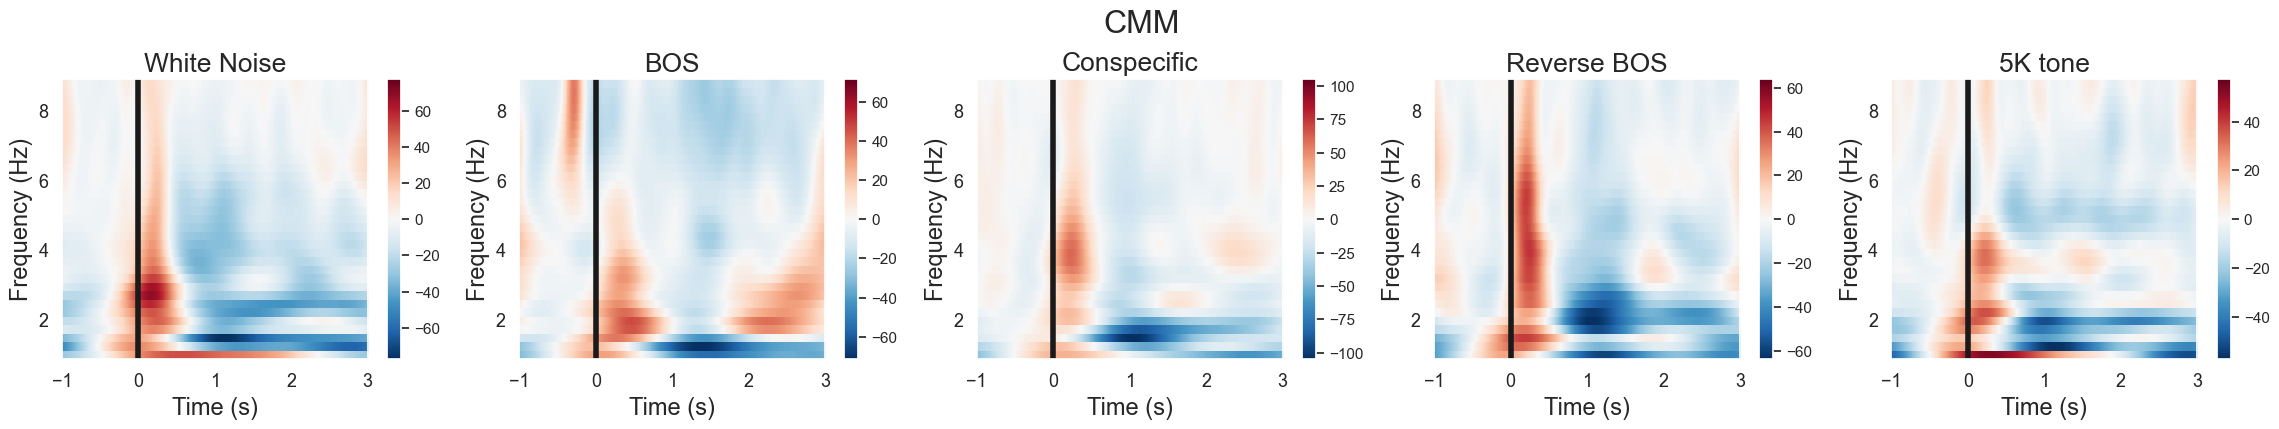

In [5]:
tf_plotN(epochs,0,0.25, "CMM")

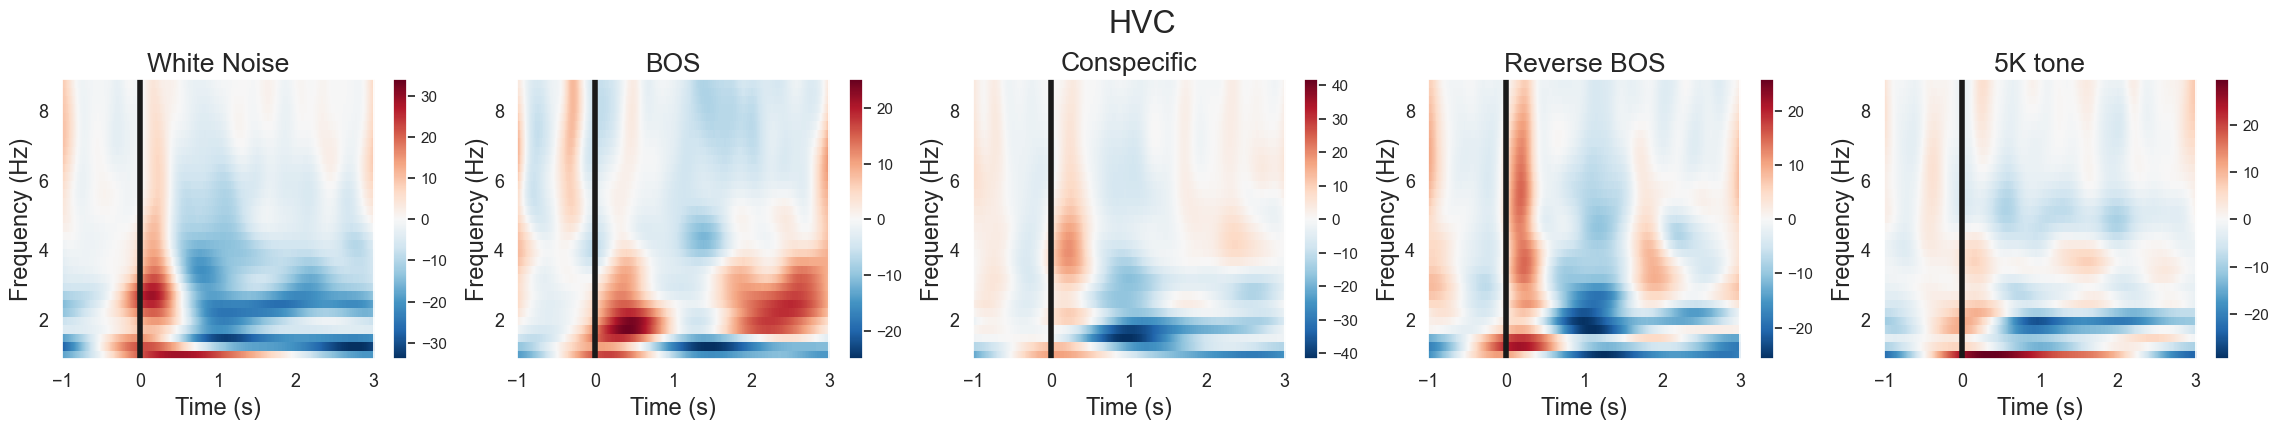

In [6]:
tf_plotN(epochs,1,0.25, "HVC")


In [9]:
def plot_ERP(epochs, channel=0, save_path=None, ymin=-40, ymax=80):
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Defining subtitles and events for different conditions
    subtitles = ['White Noise', 'BOS', 'Conspecific', 'Reverse BOS', '5K tone']
    events = ['0', '1', '2', '3', '4']
    colors = ['blue', 'green', 'red', 'orange', 'purple']  # Assigning different colors to events
    
    ax.set_title(save_path, fontsize=19, y=1, pad=20, loc='center')
    
    for i in range(5):
        # Plotting each event on the same axis with different colors and labels
        plot_epochs(ax, epochs, events[i], channel, color=colors[i], label=subtitles[i])
    
    # Setting axis labels, limits, and adding a vertical line
    ax.set_xlabel('Time', size=17)
    ax.set_ylabel('Amplitude', size=17)
    ax.axvline(x=0, color='r', linewidth=2, linestyle=':', label='Trials Onset')
    ax.set_ylim([ymin, ymax])
    
    # Adding legend for different events
    ax.legend(fontsize=12)
    ax.grid(False)

    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f"{save_path}.png", format='png', dpi=700)
    plt.savefig(f"{save_path}.eps", format='eps', dpi=700)
    
    plt.show()


In [7]:
def plot_ERP_error(epochs, channel = 0, save_path=None, ymin = -40, ymax = 80):
    fig, ax = plt.subplots(5, 1, figsize=(18, 22))
    
    subtitles = ['White Noise', 'BOS', 'Conspecific', 'Reverse BOS', '5K tone']
    event = ['0', '1', '2', '3', '4']
    ax[0].set_title(save_path, fontsize=19,  y=1.1, pad=20,loc = 'center')
    for i in range(5):
        plot_epochs_error(ax[i], epochs, event[i],channel)
        
        ax[i].set_title(f'  {subtitles[i]}', fontsize=11, y=0.1, pad=-14, loc='left')
        ax[i].grid(False)
        ax[i].set_ylim([ymin, +ymax])
        ax[i].set_xlabel('Time', size=17)
        ax[i].set_ylabel('Amplitude', size=17)
        ax[i].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')        
        ax[i].tick_params(axis='y', labelsize=15)
        ax[i].tick_params(axis='x', labelsize=15) 
    plt.tight_layout(rect=[0, 0, 1, 1])   

    plt.savefig(f"{save_path}.png", format='png', dpi=700)
    plt.savefig(f"{save_path}.eps", format='eps', dpi=700)
    plt.tight_layout()
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


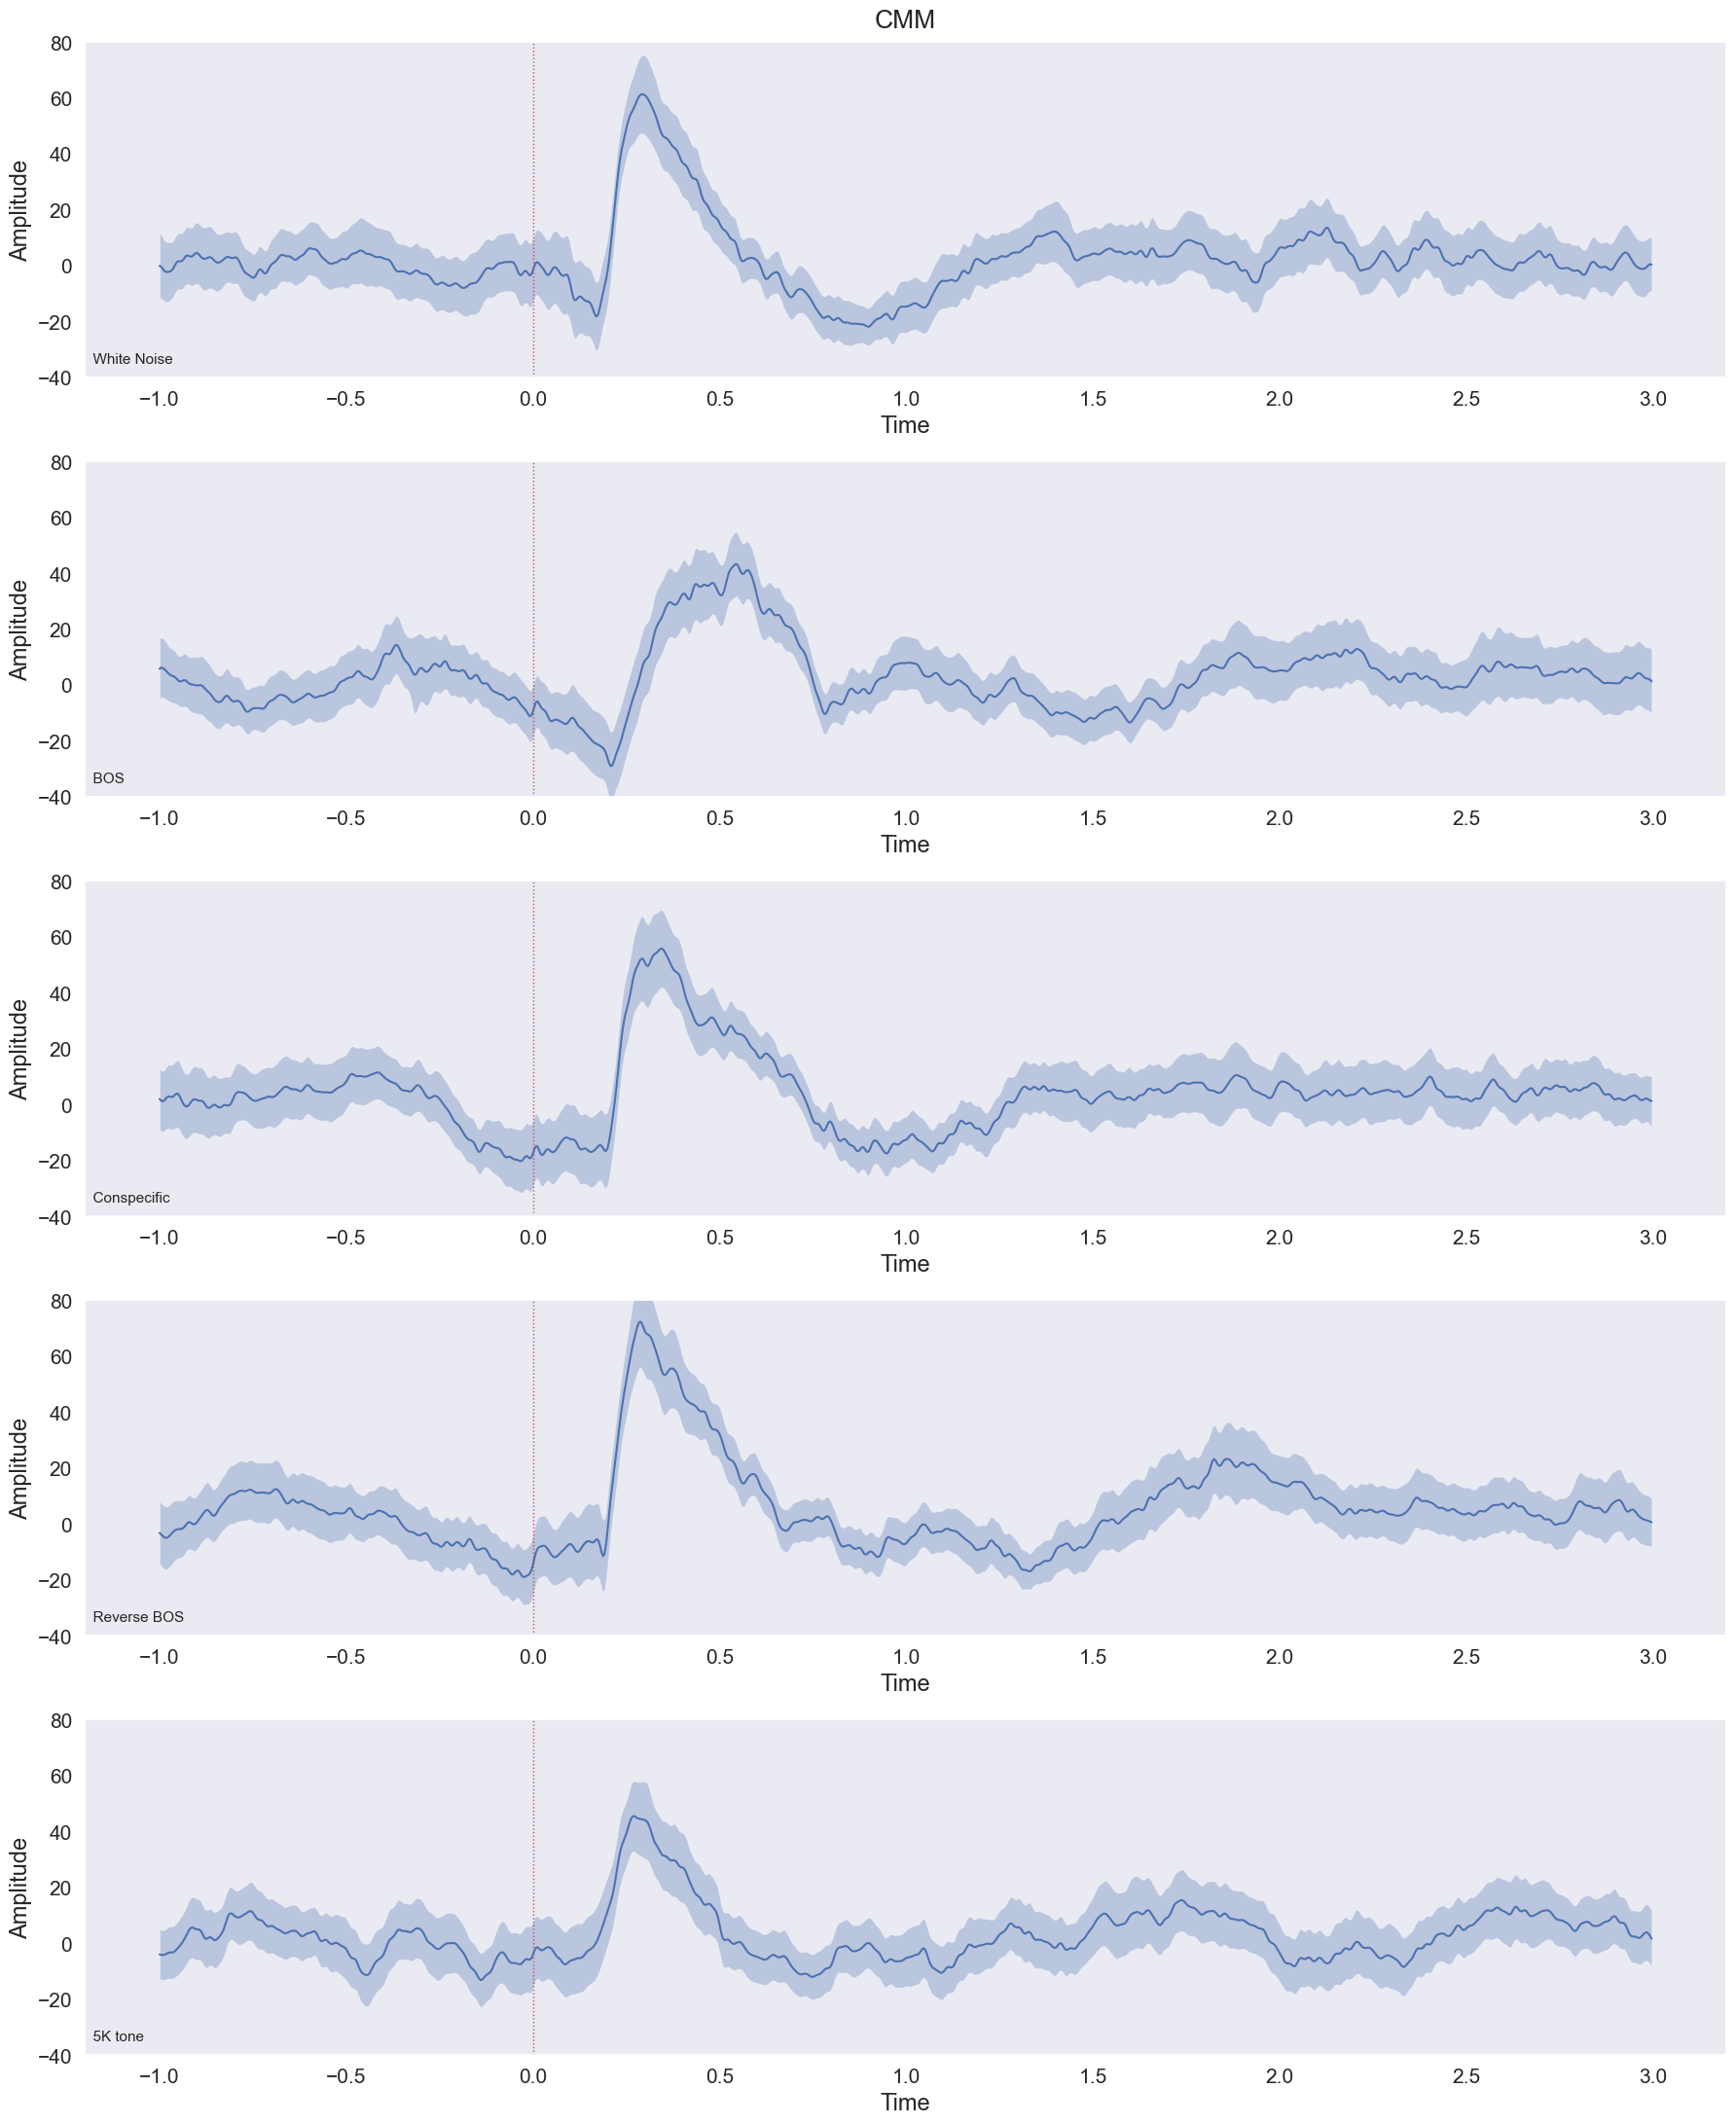

In [8]:
plot_ERP(epochs, 0 , "CMM")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


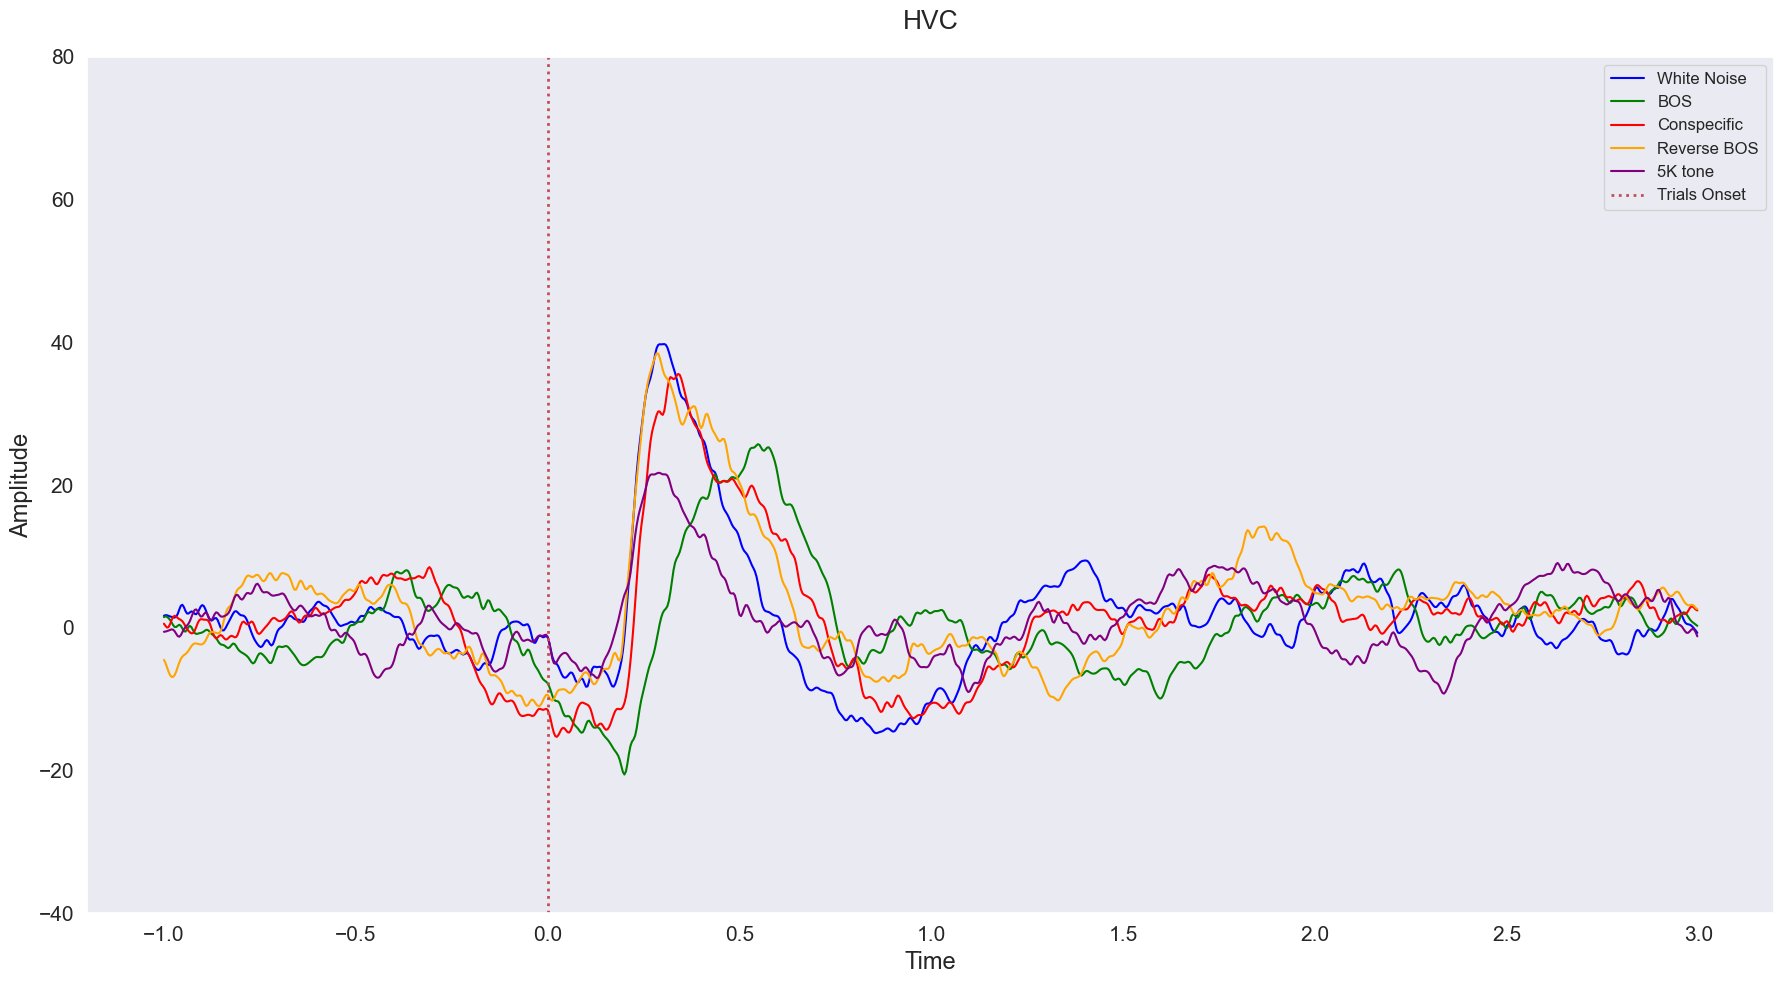

In [10]:
plot_ERP(epochs, 1 , "HVC")

In [11]:
epochs

<EpochsArray | 601 events (all good), -1 – 3 s (baseline -1 – 0 s), ~13.8 MB, data loaded,
 '0': 121
 '1': 120
 '2': 120
 '3': 120
 '4': 120>

In [25]:
def epoch_event(epoch, event, channel):
    #from 0 to 2 sec
    epoch = epoch[event].get_data()
    return np.mean(epoch[:,channel,250:750],axis = -1)

In [33]:
whitenoise_epochs = epoch_event(epochs, '0',0)
bos_epochs = epoch_event(epochs, "1",0)
conspecific_epochs = epoch_event(epochs, "2",0)
rbos_epochs = epoch_event(epochs, "3",0)
tone5k_epochs = epoch_event(epochs, "4",0)


In [46]:
whitenoise_epochs_cmm = epoch_event(epochs, '0',1)
bos_epochs_cmm = epoch_event(epochs, "1",1)
conspecific_epochs_cmm = epoch_event(epochs, "2",1)
rbos_epochs_cmm = epoch_event(epochs, "3",1)
tone5k_epochs_cmm = epoch_event(epochs, "4",1)

In [68]:
stat, p_value = wilcoxon(rbos_epochs, bos_epochs)
p_value

0.01908390911510335

In [66]:
from scipy.stats import mannwhitneyu, wilcoxon

stat, p_value = mannwhitneyu(bos_epochs, rbos_epochs)
p_value

0.029236178561896888